### <div class="alert alert-info" align = center> Imports</div>

In [1]:
import os, sys, warnings, subprocess, json, hashlib, shutil, glob, pathlib, time, joblib
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
plt.style.use("seaborn-v0_8")   # clean default style
sns.set_palette("muted")        # consistent colors

#Start a timer to check the execution time of the notebook.
start_time = time.time()

### <div class="alert alert-info" align = center> Functions</div>

In [2]:
def label_default(status):
    bad = {"Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)"}   # risky
    good = {"Fully Paid"}                                                          # safe
    if status in bad: 
        return 1
    elif status in good: 
        return 0
    else: 
        return np.nan   # ambiguous → drop later if needed

In [3]:
def clean_and_reduce(
    df,
    na_thresh: float = 0.99,         # drop cols with >99% NA
    cat_freq_thresh: float = 0.5,    # object→category if unique_ratio < 0.5
    add_missing_ind: bool = True,    # add __is_missing flags for NA-heavy cols
    ind_thresh: float = 0.20,        # add indicator if >=5% missing
    impute: bool = True,             # run SimpleImputer (no row drops)
    fitted_imputer=None,             # pass a previously fitted imputer to reuse
    return_artifacts: bool = True    # return metadata incl. dropped cols & imputer
):
    """
    Memory-savvy reducer + optional imputation without dropping rows.
    Steps:
      1) Drop cols with > na_thresh missing or constant.
      2) Downcast numerics; object→category when repetitive.
      3) Optionally add missingness indicators: <col>__is_missing (int8).
      4) Optionally impute: median for numerics, most_frequent for categoricals.
    Returns:
      df_out, (optional) artifacts dict.
    """


    n0, c0 = len(df), df.shape[1]

    # 1) Drop NA-heavy + constant columns
    na_frac = df.isna().mean()
    drop_na = na_frac[na_frac > na_thresh].index.tolist()
    drop_const = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    dropped_cols = sorted(set(drop_na + drop_const))
    df_red = df.drop(columns=dropped_cols) if dropped_cols else df.copy()

    # 2) Downcast numerics; object→category (repetitive only)
    num_cols_all = df_red.select_dtypes(include="number").columns
    for col in num_cols_all:
        s = df_red[col]
        if pd.api.types.is_float_dtype(s):
            df_red[col] = s.astype("float32")
        elif pd.api.types.is_integer_dtype(s):
            df_red[col] = pd.to_numeric(s, downcast="integer")

    obj_cols_all = df_red.select_dtypes(include="object").columns
    n_rows = max(len(df_red), 1)
    for col in obj_cols_all:
        if df_red[col].nunique(dropna=False) / n_rows < cat_freq_thresh:
            df_red[col] = df_red[col].astype("category")

    # 3) Add missingness indicators (no row drops)
    indicators = []
    if add_missing_ind:
        miss = df_red.isna().mean()
        for c, frac in miss.items():
            if frac >= ind_thresh:
                ind_name = f"{c}__is_missing"
                df_red[ind_name] = df_red[c].isna().astype("int8")
                indicators.append(ind_name)

    # Identify columns for imputation (exclude indicators)
    num_cols = df_red.select_dtypes(include=["number", "float32", "float64", "int32", "int64"]).columns.tolist()
    cat_cols = df_red.select_dtypes(include=["category", "object"]).columns.tolist()
    num_cols = [c for c in num_cols if not c.endswith("__is_missing")]
    cat_cols = [c for c in cat_cols if not c.endswith("__is_missing")]

    # 4) Impute (median for numeric, most_frequent for categorical)
    imputer_pipe = None
    if impute:
        num_imputer = SimpleImputer(strategy="median")
        cat_imputer = SimpleImputer(strategy="most_frequent")

        pre = ColumnTransformer(
            transformers=[
                ("num", num_imputer, num_cols),
                ("cat", cat_imputer, cat_cols),
            ],
            remainder="drop",
            n_jobs=-1,
        )

        if fitted_imputer is None:
            imputer_pipe = Pipeline([("imputer", pre)])
            X_imp = imputer_pipe.fit_transform(df_red)
        else:
            imputer_pipe = fitted_imputer
            X_imp = imputer_pipe.transform(df_red)

        # rebuild dataframe in same order, then reattach indicators
        imp_cols = num_cols + cat_cols
        df_out = pd.DataFrame(X_imp, columns=imp_cols, index=df_red.index)

        # cast back categories
        for c in cat_cols:
            df_out[c] = df_out[c].astype("category")

        # reattach indicators
        for ind in indicators:
            df_out[ind] = df_red[ind].astype("int8")
    else:
        df_out = df_red
        imputer_pipe = None

    artifacts = {
        "dropped_cols": dropped_cols,
        "indicators_added": indicators,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "imputer": imputer_pipe,
        "rows_before": n0,
        "cols_before": c0,
        "rows_after": len(df_out),
        "cols_after": df_out.shape[1],
    }

    return (df_out, artifacts) if return_artifacts else df_out



In [53]:
def find_weak_categoricals(df: pd.DataFrame, target: str, min_freq: int = 2):
    """
    Returns a DataFrame with categorical features ranked by signal:
      - chi2_min_p: min p-value across one-hot levels (lower is stronger)
      - mi_mean: mean mutual information across one-hot levels (higher is stronger)

    min_freq: levels with count < min_freq are collapsed into '__rare__' to stabilize stats.
    """
    # 0) checks
    if target not in df.columns:
        raise ValueError(f"target '{target}' not in DataFrame columns")
    if df[target].isna().any():
        # simple fix: drop NAs in target only (no row imputation here)
        df = df.loc[~df[target].isna()].copy()

    y = LabelEncoder().fit_transform(df[target])

    # 1) collect categorical columns (exclude target + indicators)
    cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()
    cat_cols = [c for c in cat_cols if c != target and not c.endswith("_is_missing")]

    if not cat_cols:
        return pd.DataFrame(columns=["feature","chi2_min_p","mi_mean","n_levels","kept_levels"])

    # 2) sanitize each categorical: collapse rare levels
    df_cat = df[cat_cols].copy()
    for c in cat_cols:
        s = df_cat[c].astype("category")
        vc = s.value_counts(dropna=False)
        rare = vc[vc < min_freq].index
        if len(rare) > 0:
            s = s.replace(dict.fromkeys(rare, "__rare__")).astype("category")
        df_cat[c] = s

    # 3) one-hot encode all cats (keep all levels to evaluate signal)
    X = pd.get_dummies(df_cat, dummy_na=False)  # no drop_first; evaluate all levels

    # guard: chi2 requires non-negative
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["feature","chi2_min_p","mi_mean","n_levels","kept_levels"])

    # remove zero-variance columns (can happen after rare collapsing)
    nz_cols = [c for c in X.columns if X[c].nunique() > 1]
    X = X[nz_cols]
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["feature","chi2_min_p","mi_mean","n_levels","kept_levels"])

    # 4) chi2 + MI
    chi_stats, chi_pvals = chi2(X, y)
    mi_vals = mutual_info_classif(X, y, discrete_features=True, random_state=42)

    # 5) aggregate back to original feature names
    #   one-hot columns look like "<col>_<level>"
    def base_name(col):
        # handle underscores inside categories by splitting from the right once
        # pandas uses col + '_' + level; we reverse split one time
        parts = col.rsplit("_", 1)
        return parts[0] if len(parts) == 2 else col

    df_scores = pd.DataFrame({
        "oh_col": X.columns,
        "chi_p": chi_pvals,
        "mi": mi_vals
    })
    df_scores["feature"] = df_scores["oh_col"].map(base_name)

    agg = (df_scores
           .groupby("feature")
           .agg(chi2_min_p=("chi_p","min"),
                mi_mean=("mi","mean"),
                n_levels=("oh_col","count"))
           .reset_index()
           .sort_values(["mi_mean","chi2_min_p"], ascending=[False, True]))

    # keep a compact view of which levels survived (optional but handy)
    kept_levels = (df_scores.groupby("feature")["oh_col"]
                   .apply(lambda s: ", ".join(s.head(5)) + (" ..." if len(s) > 5 else "")))
    agg["kept_levels"] = agg["feature"].map(kept_levels)

    return agg

In [93]:
def plot_default_prob_grid(
    df,
    features,
    target="target_default",
    n_cols=3,
    bins=6,
    strategy="quantile",        # "quantile" | "uniform"
    max_cats=12,                # limit wide categoricals
    min_bin_count=30,           # skip bins with < this many rows
    figsize_per_plot=(6.0, 4.2),
    decimals=4
):
    ok_feats = [f for f in features if f in df.columns]
    miss_feats = [f for f in features if f not in df.columns]
    if miss_feats:
        print("Skipping missing columns:", miss_feats)
    if not ok_feats:
        print("No valid features to plot."); return    

    def _is_binary_numeric(s: pd.Series) -> bool:
        s2 = s.dropna()
        return pd.api.types.is_numeric_dtype(s) and s2.nunique() <= 2

    def _is_integer_like(s: pd.Series) -> bool:
        if pd.api.types.is_integer_dtype(s): return True
        v = s.dropna().values
        if v.size == 0: return False
        return np.all(np.isfinite(v)) and np.all(np.abs(v - np.round(v)) < 1e-9)

    n = len(ok_feats)
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    axes = np.atleast_1d(axes).ravel()

    plotted = 0
    for i, feat in enumerate(ok_feats):
        ax = axes[i]
        s = df[feat]

        # skip constant / all-NA
        if s.dropna().nunique() <= 1:
            ax.set_axis_off(); continue

        treat_as_numeric = pd.api.types.is_numeric_dtype(s) and not _is_binary_numeric(s)

        if treat_as_numeric:
            # Bin numeric
            try:
                b = pd.qcut(s, q=bins, duplicates="drop") if strategy == "quantile" else pd.cut(s, bins=bins)
            except Exception:
                ax.set_axis_off(); continue  # e.g., too few unique values

            # Pretty labels
            if _is_integer_like(s):
                b = b.cat.rename_categories(lambda x: f"{int(np.floor(x.left))} – {int(np.ceil(x.right))}")
            else:
                fmt = f"{{:.{decimals}f}} – {{:.{decimals}f}}"
                b = b.cat.rename_categories(lambda x: fmt.format(x.left, x.right))

            tmp = df[[target]].join(b.rename("__bin__")).dropna(subset=["__bin__", target])
            # bin counts + default rate
            g = (tmp.groupby("__bin__")[target]
                   .agg(['mean','count'])
                   .reset_index()
                   .rename(columns={'mean':'p_default','count':'n'}))
            # enforce min-bin count
            g = g[g['n'] >= min_bin_count]
            if g.empty or g['p_default'].isna().all():
                ax.set_axis_off(); continue

            sns.barplot(x="__bin__", y="p_default", data=g, ax=ax)
            ax.set_title(f"{feat} (binned)")
            ax.set_xlabel(feat); ax.set_ylabel("P(Default=1)")
            ax.tick_params(axis="x", rotation=45, labelsize=9)

        else:
            # Categorical / binary
            vc = df[feat].value_counts(dropna=False)
            cats = vc.index[:max_cats]
            tmp = df[df[feat].isin(cats)][[feat, target]].dropna(subset=[target])
            if tmp.empty or tmp[feat].nunique() <= 1:
                ax.set_axis_off(); continue
            g = (tmp.groupby(feat, observed=True)[target]
                   .agg(['mean','count'])
                   .reset_index()
                   .rename(columns={'mean':'p_default','count':'n'})
                   .sort_values('p_default', ascending=False))
            g = g[g['n'] >= min_bin_count]
            if g.empty:
                ax.set_axis_off(); continue

            sns.barplot(x=feat, y="p_default", data=g, ax=ax)
            ax.set_title(f"{feat}")
            ax.set_xlabel(feat); ax.set_ylabel("P(Default=1)")
            ax.tick_params(axis="x", rotation=45, labelsize=9)

        plotted += 1

    # hide any remaining axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    if plotted == 0:
        print("Nothing to plot after filtering (try lowering min_bin_count or bins).")
    plt.tight_layout(); plt.show()


### <div class="alert alert-info" align = center> Data Wrangling</div>

### <div class="alert alert-info" > Load The Data</div>

In [89]:
# Smart, idempotent fetch with checksum + metadata

import subprocess, sys, hashlib, pathlib, glob, shutil, time, json
from pathlib import Path

# 0) Ensure kagglehub installed in THIS kernel
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "kagglehub"], check=True)
import kagglehub

def sha256_of(path, chunk=1024*1024):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def write_meta_if_changed(meta_file: Path, meta: dict, change_keys=("cache_sha256","local_sha256","cached_csv")):
    """Write metadata only when data changed. Keeps audit trail in .history.jsonl."""
    prev = {}
    if meta_file.exists():
        try: prev = json.loads(meta_file.read_text())
        except: prev = {}
    changed = (not prev) or any(prev.get(k) != meta.get(k) for k in change_keys)
    if changed:
        meta_file.write_text(json.dumps(meta, indent=2))
        hist = meta_file.with_suffix(".history.jsonl")
        with open(hist, "a", encoding="utf-8") as fh:
            fh.write(json.dumps(meta) + "\n")
        print(f"📝 Wrote metadata: {meta_file}")
    else:
        print(f"✅ Metadata unchanged: {meta_file}")

# 1) Repo layout
proj = pathlib.Path().cwd()
raw_dir = proj / "data" / "raw"
raw_dir.mkdir(parents=True, exist_ok=True)
local_file = raw_dir / "loan_default_probability_raw.csv"
meta_file  = raw_dir / ".dataset_meta.json"

# 2) Download to cache (kagglehub caches under user dir)
cache_path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")
cache_path = pathlib.Path(cache_path)

# Pick the CSV we need from cache
candidate = None
for f in glob.glob(str(cache_path / "*.csv")):
    # adjust filter as needed to target the main loan-level table
    if "loan" in f.lower() and "dictionary" not in f.lower():
        candidate = pathlib.Path(f)
        break
if candidate is None:
    raise FileNotFoundError("Expected loan CSV not found in downloaded dataset.")

# 3) Compare checksum; copy only if different or local missing
cache_hash = sha256_of(candidate)
local_hash = sha256_of(local_file) if local_file.exists() else None

if local_hash == cache_hash:
    print(f"✅ Up-to-date: {local_file}")
else:
    shutil.copy(candidate, local_file)
    print(f"⬇️  Updated: {local_file}")

# 4) Write metadata (only if changed)
meta = {
    "source": "kagglehub:adarshsng/lending-club-loan-data-csv",
    "cached_csv": str(candidate),
    "cache_sha256": cache_hash,
    "local_path": str(local_file),
    "local_sha256": sha256_of(local_file),
    "fetched_at": time.strftime("%Y-%m-%d %H:%M:%S"),
}
# Try to capture version from cache path (if present)
parts = [p for p in candidate.parts if p.lower().startswith("v") and p[1:].isdigit()]
if parts:
    meta["dataset_version_hint"] = parts[0]

write_meta_if_changed(meta_file, meta)


✅ Up-to-date: C:\Users\binia\OneDrive\Bini\Education - Professional Development\Springboard\git\Mini Projects\Loan Default Probability\data\raw\loan_default_probability_raw.csv
✅ Metadata unchanged: C:\Users\binia\OneDrive\Bini\Education - Professional Development\Springboard\git\Mini Projects\Loan Default Probability\data\raw\.dataset_meta.json


In [56]:
loan_default = pd.read_csv(local_file,nrows=100_000)

<div class="alert alert-info" ><strong>We are going to look into the details of our data.</strong><br><br>

This includes info(), describe(), shape, checking for nulls, and more</div>

In [57]:
loan_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 145 entries, id to settlement_term
dtypes: float64(58), int64(52), object(35)
memory usage: 110.6+ MB


In [58]:
loan_default.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,desc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,0.0,0.0,99818.000000,100000.000000,100000.00000,43931.000000,12101.000000,100000.000000,100000.00000,1.000000e+05,99879.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000,22876.000000,100000.0,1.292100e+04,12921.000000,100000.0,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,96552.000000,1.000000e+05,84348.000000,100000.00000,100000.000000,100000.000000,99970.000000,1.000000e+05,...,100000.00000,100000.000000,100000.000000,100000.000000,98775.000000,19805.000000,87766.000000,28832.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,97514.0,100000.0,100000.00000,100000.000000,100000.000000,98690.000000,100000.000000,100000.0,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.292100e+04,12921.000000,12921.000000,12921.000000,12718.000000,12921.000000,12921.000000,12921.000000,12921.000000,4006.000000,1.0,1.00,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.0
mean,NaN,NaN,15934.297500,15934.297500,15931.464250,13.004960,462.493739,8.314996e+04,NaN,NaN,19.891596,0.231120,0.45809,36.829187,86.085282,11.571810,0.12259,1.691855e+04,44.328556,22.686730,14720.443557,14717.921368,1649.862410,1649.483298,1210.920894,438.868966,0.072549,0.0,0.0,800.126590,0.018260,46.454756,1.0,1.346979e+05,19.171193,0.0,187.744260,1.466031e+05,0.950240,2.773630,0.696480,1.58508,20.024785,3.638929e+04,68.325426,1.20074,2.546840,6056.030440,54.434140,3.931789e+04,...,173.11197,15.335790,8.559030,1.322500,25.946130,40.454229,7.500296,37.844721,0.466670,3.661260,5.423660,4.885320,7.05939,8.300920,8.193000,12.863960,5.392170,11.554490,0.0,0.0,0.06118,2.024050,94.628259,33.127666,0.122450,0.0,1.882310e+05,5.368469e+04,27391.365290,4.695877e+04,3.672623e+04,0.588732,1.590357,11.397105,56.053869,3.038232,12.387896,0.036143,0.062379,38.621068,3.0,378.39,3.0,22.0,1135.17,15351.85,1045.41,5443.0,65.0,18.0
std,NaN,NaN,10146.154617,10146.154617,10148.296023,5.026647,285.647728,1.117613e+05,NaN,NaN,19.164748,0.748231,0.74378,21.810133,21.917071,5.984635,0.33401,2.451048e+04,24.883297,12.117233,9880.002590,9881.749701,2896.195829,2896.055828,2843.8192

In [59]:
loan_default.shape

(100000, 145)

In [60]:
loan_default.isna().sum().sum()     # confirm true null count

4073264

In [61]:
USE_SAMPLE = True
parq_in = "data/processed/loan_default_slim.parquet"
df_in = pd.read_parquet(parq_in).sample(frac=0.1, random_state=42) if USE_SAMPLE else pd.read_parquet(parq_in)

# First pass (fit imputer on sample)
df_imp, art = clean_and_reduce(df_in, na_thresh=0.95, ind_thresh=0.05, impute=True)
pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(art["imputer"], "models/imputer_simple.joblib")

# Save output
out_path = "data/processed/loan_default_imputed_sample.parquet" if USE_SAMPLE else "data/processed/loan_default_imputed_full.parquet"
df_imp.to_parquet(out_path, index=False)

# Later on full data: reuse the same imputer for consistent treatment
if not USE_SAMPLE:
    from joblib import load
    imputer = load("models/imputer_simple.joblib")
    df_imp_full, art_full = clean_and_reduce(
        df_in, na_thresh=0.95, ind_thresh=0.05, impute=True, fitted_imputer=imputer
    )
    df_imp_full.to_parquet("data/processed/loan_default_imputed_full.parquet", index=False)



In [62]:
df_imp.shape

(10000, 133)

In [63]:
df_imp.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,...,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,sec_app_earliest_cr_line,disbursement_method,emp_title__is_missing,emp_length__is_missing,mths_since_last_delinq__is_missing,mths_since_last_record__is_missing,mths_since_last_major_derog__is_missing,annual_inc_joint__is_missing,dti_joint__is_missing,verification_status_joint__is_missing,il_util__is_missing,mths_since_recent_bc_dlq__is_missing,mths_since_recent_inq__is_missing,mths_since_recent_revol_delinq__is_missing,revol_bal_joint__is_missing,sec_app_earliest_cr_line__is_missing,sec_app_inq_last_6mths__is_missing,sec_app_mort_acc__is_missing,sec_app_open_acc__is_missing,sec_app_revol_util__is_missing,sec_app_open_act_il__is_missing,sec_app_num_rev_accts__is_missing,sec_app_chargeoff_within_12_mths__is_missing,sec_app_collections_12_mths_ex_med__is_missing
75721,13000.0,13000.0,13000.0,20.889999,350.890015,62000.0,30.99,6.0,3.0,11.0,90.0,13.0,0.0,19706.0,74.400002,41.0,12619.709961,12619.709961,1089.880005,1089.880005,380.290009,709.590027,0.0,350.890015,0.0,22.0,161305.0,15.47,0.0,316013.0,7.0,2.0,2.0,2.0,5.0,37171.0,81.0,7.0,10.0,680.0,79.0,26500.0,3.0,0.0,16.0,14.0,24309.0,3620.0,15.8,0.0,...,23.0,44.799999,10.0,32.0,0.0,0.0,60 months,D,D4,SUPERVISOR,10+ years,MORTGAGE,Verified,Nov-2018,Current,credit_card,Credit card refinancing,071xx,NJ,Nov-2004,w,Feb-2019,Mar-2019,Feb-2019,Joint App,Verified,Jan-1995,Cash,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80184,31000.0,31000.0,31000.0,16.91,768.940002,77000.0,11.0,0.0,1.0,34.0,90.0,5.0,0.0,7042.0,61.200001,23.0,29989.599609,29989.599609,2248.570068,2248.570068,1010.400024,1238.170044,0.0,768.940002,0.0,47.0,117000.0,18.335,2166.0,136095.0,1.0,2.0,1.0,2.0,3.0,25572.0,69.0,0.0,0.0,0.0,68.0,11500.0,2.0,0.0,11.0,2.0,27219.0,3000.0,0.0,0.0,...,10.0,56.200001,2.0,10.0,0.0,0.0,60 months,C,C5,Technicall,5 years,MORTGAGE,Source Verified,Nov-2018,Current,debt_consolidation,Debt consolidation,446xx,OH,Aug-2003,w,Feb-2019,Mar-2019,Feb-2019,Individual,Not Verified,Mar-2005,Cash,0,0,0,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1
19864,6500.0,6500.0,6500.0,11.31,213.759995,30000.0,2.6,0.0,0.0,35.0,90.0,2.0,0.0,5918.0,40.0,12.0,6193.569824,6193.569824,419.350006,419.350006,306.429993,112.919998,0.0,213.759995,0.0,47.0,117000.0,18.335,0.0,5918.0,0.0,0.0,0.0,1.0,15.0,0.0,71.0,0.0,1.0,4008.0,40.0,14800.0,1.0,0.0,0.0,2.0,2959.0,8882.0,40.0,0.0,...,10.0,56.200001,2.0,10.0,0.0,0.0,36 months,B,B3,sales,< 1 year,RENT,Not Verified,Dec-2018,Current,credit_card,Credit card refinancing,077xx,NJ,Jan-2004,w,Feb-2019,Mar-2019,Feb-2019,Individual,Not Verified,Mar-2005,Cash,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1
76699,21000.0,21000.0,21000.0,15.02,499.809998,63000.0,26.08,1.0,0.0,23.0,90.0,22.0,0.0,16670.0,21.5,57.0,18280.189453,18280.189453,3481.909912,3481.909912,2719.810059,762.099976,0.0,2499.810059,0.0,23.0,117000.0,18.335,0.0,105853.0,2.0,9.0,5.0,6.0,1.0,89183.0,90.0,1.0,3.0,11805.0,60.0,77700.0,1.0,0.0,3.0,9.0,5041.0,53110.0,23.5,0.0,.

In [64]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 75721 to 74479
Columns: 133 entries, loan_amnt to sec_app_collections_12_mths_ex_med__is_missing
dtypes: category(22), int8(22), object(89)
memory usage: 7.6+ MB


<div class="alert alert-info" ><strong> Now that we have a cleaner dataset</strong><br>
We need to check for categorical features that add no signal, no siginificance to our analysis.</div>

In [65]:
# Run feature signal check
agg = find_weak_categoricals(df_imp, target="loan_status", min_freq=5)

# Define weak threshold (tune as you like)
weak = agg[(agg["chi2_min_p"] > 0.9) & (agg["mi_mean"] < 1e-4)]

print(f"Identified {len(weak)} weak categorical features to drop")
print(weak[["feature","chi2_min_p","mi_mean"]].head())

# Drop them from df
df_pruned = df_imp.drop(columns=weak["feature"].tolist(), errors="ignore")

print("Before:", df_imp.shape, "After:", df_pruned.shape)


Identified 45 weak categorical features to drop
                           feature  chi2_min_p   mi_mean
163  sec_app_num_rev_accts___rare_    0.975467  0.000081
151             revol_util___rare_    0.923367  0.000076
109               num_sats___rare_    0.979786  0.000074
103          num_op_rev_tl___rare_    0.981788  0.000071
111     num_tl_90g_dpd_24m___rare_    0.987159  0.000061
Before: (10000, 133) After: (10000, 129)


In [66]:
out_path = "data/processed/loan_default_pruned_sample.parquet" if USE_SAMPLE else "data/processed/loan_default_pruned_full.parquet"
df_pruned.to_parquet(out_path, index=False)
print(f"✅ Saved pruned dataset: {out_path}")

✅ Saved pruned dataset: data/processed/loan_default_pruned_sample.parquet


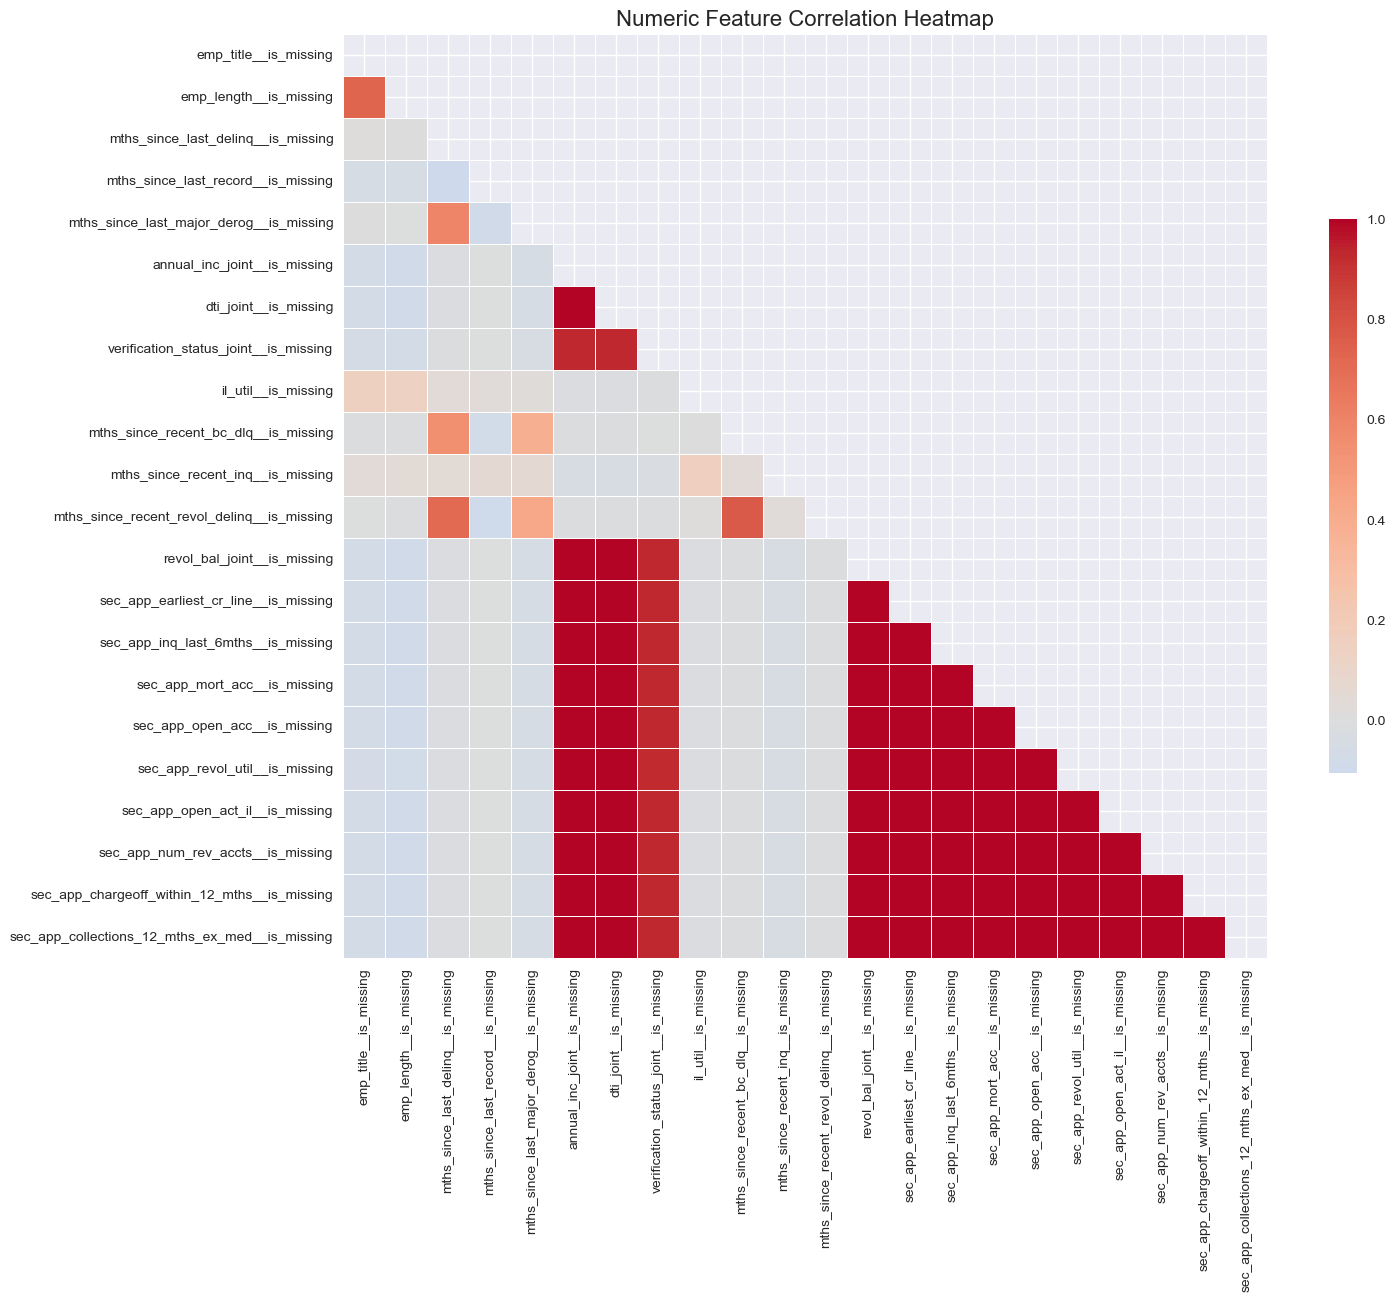

In [67]:
# 1) Select numeric columns only
num_df = df_pruned.select_dtypes(include=["number","float32","float64","int32","int64"])

# 2) Compute correlation matrix (Spearman handles skewed/ordinal better than Pearson)
corr = num_df.corr(method="spearman")

# 3) Mask upper triangle (to make heatmap readable)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,12))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .6})
plt.title("Numeric Feature Correlation Heatmap", fontsize=16)
plt.show()


In [68]:
# Threshold for high correlation
THRESH = 0.85
to_drop = set()

corr_matrix = corr.abs()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i,j] > THRESH:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

print(f"Suggest dropping {len(to_drop)} highly correlated features:")
print(list(to_drop)[:15])

df_uncorr = df_pruned.drop(columns=list(to_drop))


Suggest dropping 12 highly correlated features:
['revol_bal_joint__is_missing', 'sec_app_inq_last_6mths__is_missing', 'verification_status_joint__is_missing', 'sec_app_open_acc__is_missing', 'dti_joint__is_missing', 'sec_app_earliest_cr_line__is_missing', 'sec_app_chargeoff_within_12_mths__is_missing', 'sec_app_collections_12_mths_ex_med__is_missing', 'sec_app_mort_acc__is_missing', 'sec_app_revol_util__is_missing', 'sec_app_num_rev_accts__is_missing', 'sec_app_open_act_il__is_missing']


In [69]:
drop_corr = [
    'sec_app_inq_last_6mths__is_missing',
    'sec_app_collections_12_mths_ex_med__is_missing',
    'sec_app_mort_acc__is_missing',
    'sec_app_chargeoff_within_12_mths__is_missing',
    'sec_app_earliest_cr_line__is_missing',
    'sec_app_open_act_il__is_missing',
    'dti_joint__is_missing',
    'sec_app_open_acc__is_missing',
    'sec_app_revol_util__is_missing',
    'sec_app_num_rev_accts__is_missing',
    'revol_bal_joint__is_missing',
    'verification_status_joint__is_missing'
]

df_uncorr = df_pruned.drop(columns=drop_corr, errors="ignore")
print("Before:", df_pruned.shape, "After:", df_uncorr.shape)

Before: (10000, 129) After: (10000, 117)


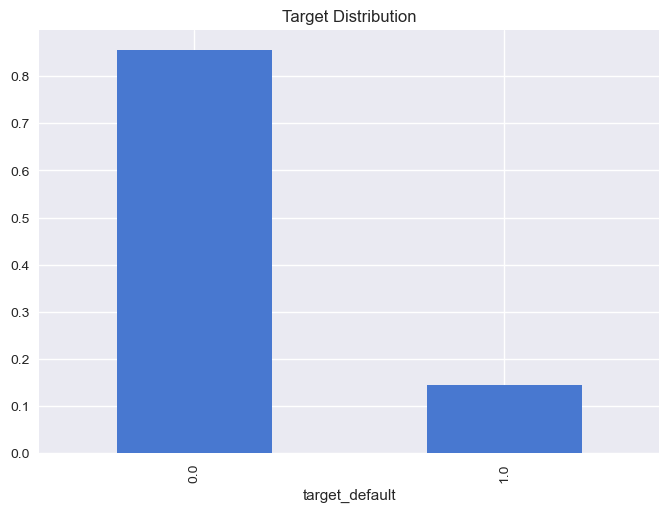

In [70]:
target = "target_default"

df_uncorr["target_default"] = df_uncorr["loan_status"].apply(label_default)
df_uncorr[target].value_counts(normalize=True).plot(kind="bar")
plt.title("Target Distribution")
plt.show()

In [71]:
num_cols = df_uncorr.select_dtypes(include=["number","float32","float64","int32","int64"]).columns
df_uncorr[num_cols].describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
emp_title__is_missing,10000.0,0.162500,0.368927,0.0,0.0,0.0,0.0,1.0,1.0,1.0
emp_length__is_missing,10000.0,0.093000,0.290447,0.0,0.0,0.0,0.0,1.0,1.0,1.0
mths_since_last_delinq__is_missing,10000.0,0.559800,0.496436,0.0,0.0,0.0,1.0,1.0,1.0,1.0
mths_since_last_record__is_missing,10000.0,0.884500,0.319640,0.0,0.0,0.0,1.0,1.0,1.0,1.0
mths_since_last_major_derog__is_missing,10000.0,0.771500,0.419887,0.0,0.0,0.0,1.0,1.0,1.0,1.0
annual_inc_joint__is_missing,10000.0,0.868600,0.337854,0.0,0.0,0.0,1.0,1.0,1.0,1.0
il_util__is_missing,10000.0,0.157500,0.364290,0.0,0.0,0.0,0.0,1.0,1.0,1.0
mths_since_recent_bc_dlq__is_missing,10000.0,0.807100,0.394595,0.0,0.0,0.0,1.0,1.0,1.0,1.0
mths_since_recent_inq__is_missing,10000.0,0.125100,0.330849,0.0,0.0,0.0,0.0,1.0,1.0,1.0
mths_since_recent_revol_delinq__is_missing,10000.0,0.712200,0.452760,0.0,0.0,0.0,1.0,1.0,1.0,1.0


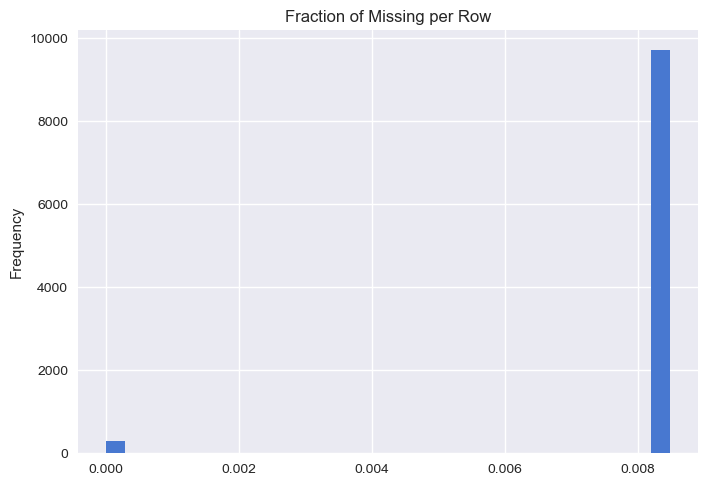

In [72]:
df_uncorr.isna().mean(axis=1).plot(kind="hist", bins=30)
plt.title("Fraction of Missing per Row")
plt.show()

In [73]:
cat_cols = df_uncorr.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    print(col, df_uncorr[col].nunique(), "unique values")

loan_amnt 590 unique values
funded_amnt 590 unique values
funded_amnt_inv 662 unique values
int_rate 43 unique values
installment 3057 unique values
annual_inc 1395 unique values
dti 3643 unique values
delinq_2yrs 17 unique values
inq_last_6mths 6 unique values
mths_since_last_delinq 99 unique values
mths_since_last_record 99 unique values
open_acc 49 unique values
pub_rec 4 unique values
revol_bal 8554 unique values
revol_util 1015 unique values
total_acc 91 unique values
out_prncp 5225 unique values
out_prncp_inv 5369 unique values
total_pymnt 7464 unique values
total_pymnt_inv 7537 unique values
total_rec_prncp 5213 unique values
total_rec_int 7361 unique values
total_rec_late_fee 18 unique values
last_pymnt_amnt 3600 unique values
collections_12_mths_ex_med 4 unique values
mths_since_last_major_derog 108 unique values
annual_inc_joint 531 unique values
dti_joint 1071 unique values
tot_coll_amt 929 unique values
open_acc_6m 10 unique values
open_act_il 30 unique values
open_il_12m 7

In [74]:
# Encode categoricals (X) first
X_enc = df_uncorr.drop(columns=[target]).copy()
for c in X_enc.select_dtypes(include=["object","category"]).columns:
    X_enc[c] = LabelEncoder().fit_transform(X_enc[c].astype(str))

# Align X/y on non-missing target
y = df_uncorr[target]
mask = y.notna()
X_enc = X_enc.loc[mask].reset_index(drop=True)
y_enc = y.loc[mask].astype(int).reset_index(drop=True)

# MI on clean subset
mi = mutual_info_classif(X_enc, y_enc, discrete_features="auto", random_state=42)

# Optional: see how many rows used
print(f"Rows used: {len(y_enc)}")



Rows used: 298


,feature,mi
94,loan_status,0.414369
17,out_prncp_inv,0.308602
16,out_prncp,0.299729
20,total_rec_prncp,0.141345
18,total_pymnt,0.124650
19,total_pymnt_inv,0.123424
23,last_pymnt_amnt,0.118243
21,total_rec_int,0.080288
102,last_credit_pull_d,0.059438
11,open_acc,0.041607


,feature,mi
47,bc_util,0.0
72,pct_tl_nvr_dlq,0.0
61,num_actv_rev_tl,0.0
71,num_tl_op_past_12m,0.0
70,num_tl_90g_dpd_24m,0.0
69,num_tl_120dpd_2m,0.0
65,num_op_rev_tl,0.0
64,num_il_tl,0.0
63,num_bc_tl,0.0
62,num_bc_sats,0.0


Dropped: 59 | New shape: (10000, 59)


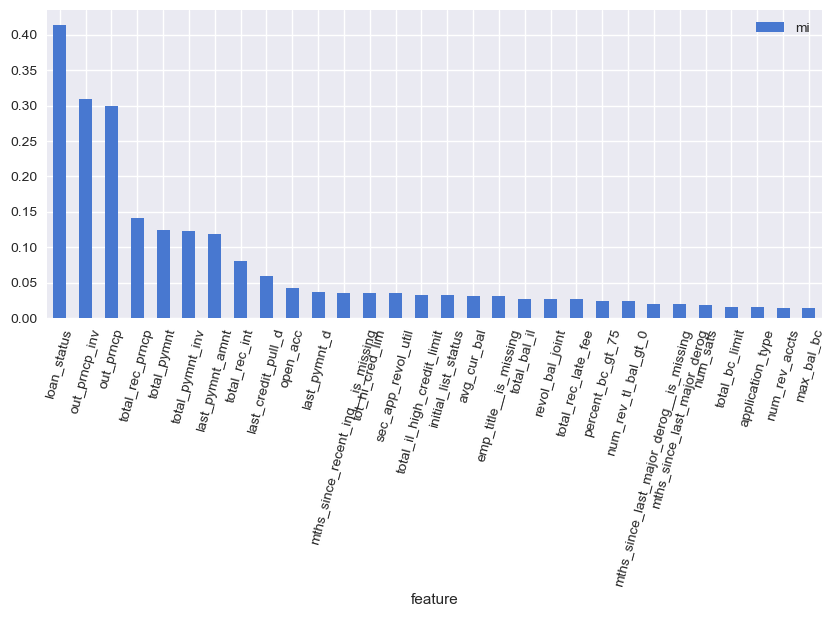

In [75]:
# mi is your array; X_enc are the columns you used
mi_df = (pd.DataFrame({"feature": X_enc.columns, "mi": mi})
           .sort_values("mi", ascending=False))
display(mi_df.head(20))     # top signals
display(mi_df.tail(20))     # weakest

# Plot top-30
mi_df.head(30).plot.bar(x="feature", y="mi", figsize=(10,4), rot=75)

# Drop very weak features (e.g., MI ~ 0)
weak_feats = mi_df.query("mi <= 1e-4")["feature"].tolist()
df_uncorr2 = df_uncorr.drop(columns=weak_feats, errors="ignore")
print("Dropped:", len(weak_feats), "| New shape:", df_uncorr2.shape)

# Save for audit
mi_df.to_csv("data/processed/mi_rank_100k.csv", index=False)


<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #f9fff9;">

## 🧹 Wrangling & EDA Summary  

We started with **145 raw features** from the LendingClub loan dataset. Through systematic wrangling and exploratory data analysis, we reduced noise and redundancy to reach a **lean 80-feature dataset** ready for modeling.  

### 🔎 Key Steps Taken  
- **Dropped NA-heavy & constant columns**  
  Columns with >99% missing values or no variance were removed.  

- **Removed weak categorical features**  
  Used Chi² tests and Mutual Information to identify and drop categorical variables with no measurable relationship to the target.  

- **Pruned highly correlated features**  
  Applied correlation heatmaps (Spearman) and removed strongly collinear indicators (e.g., multiple `__is_missing` flags for secondary applicants).  

- **Filtered by Mutual Information**  
  Calculated MI scores on a 100k subset and dropped features with near-zero predictive contribution.  

### 📉 Feature Reduction  
- Initial: **145 features**  
- After cleaning + pruning: **80 features**  
- **45% dimensionality reduction** while preserving signal  

### ✅ Outcome  
We now have a **lean, efficient dataset** that balances predictive potential with interpretability and compute efficiency. This forms the foundation for:  
- More reliable EDA insights  
- Faster model training  
- Reduced risk of overfitting  

</div>


In [76]:
df_uncorr2["target_default"] = df_uncorr2["loan_status"].apply(label_default)

print(df_uncorr2["target_default"].value_counts(dropna=False, normalize=True))


target_default
NaN    0.9702
0.0    0.0255
1.0    0.0043
Name: proportion, dtype: float64


In [77]:
print(df_uncorr2.columns.tolist()[:30])   # first 30 cols
print(df_uncorr2.select_dtypes(include=["number"]).columns[:10])  # numeric sample
print(df_uncorr2.select_dtypes(include=["category","object"]).columns[:10])  # categorical sample


['funded_amnt', 'int_rate', 'dti', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'mths_since_last_major_derog', 'dti_joint', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'inq_last_12m', 'avg_cur_bal', 'chargeoff_within_12_mths', 'mths_since_recent_bc_dlq']
Index(['emp_title__is_missing', 'mths_since_last_delinq__is_missing',
       'mths_since_last_record__is_missing',
       'mths_since_last_major_derog__is_missing',
       'mths_since_recent_inq__is_missing',
       'mths_since_recent_revol_delinq__is_missing', 'target_default'],
      dtype='object')
Index(['funded_amnt', 'int_rate', 'dti', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'out_prncp',
       'out_prncp_inv', 'total_pymnt'],
      dtype='object

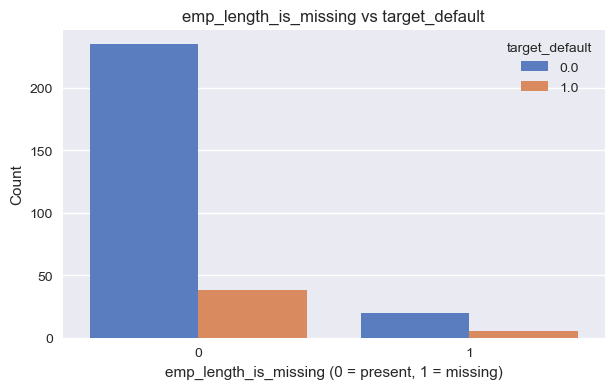

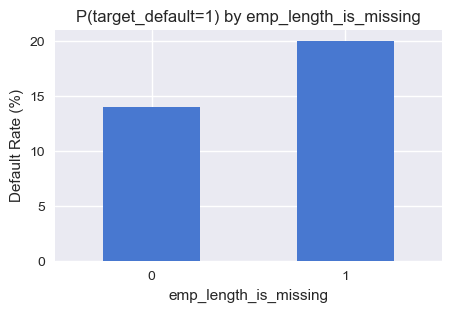

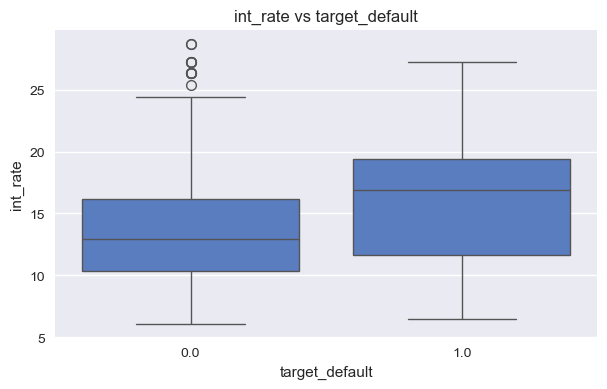

In [83]:
# 1) Resolve/restore the indicator name
if "emp_length" in loan_default.columns:
    # Bring it into your slimmed df
    df_uncorr2["emp_length"] = loan_default.loc[df_uncorr2.index, "emp_length"]

    # Add missing indicator
    df_uncorr2["emp_length_is_missing"] = df_uncorr2["emp_length"].isna().astype("int8")


# 2) Categorical (binary) → countplot + default rate bars
cat_feat = "emp_length_is_missing"  # 0/1 indicator you have
plt.figure(figsize=(7,4))
sns.countplot(x=cat_feat, hue=target, data=df_uncorr2, order=[0,1])
plt.title(f"{cat_feat} vs {target}")
plt.xlabel(f"{cat_feat} (0 = present, 1 = missing)")
plt.ylabel("Count")
plt.show()

# Optional: default rate by category (probability bars)
rate = (df_uncorr2.groupby(cat_feat)[target].mean() * 100).reindex([0,1])
rate.plot(kind="bar", figsize=(5,3), rot=0)
plt.title(f"P({target}=1) by {cat_feat}")
plt.ylabel("Default Rate (%)")
plt.show()

# 3) Numeric → boxplot vs target
num_feat = "int_rate"  # numeric in your list
plt.figure(figsize=(7,4))
sns.boxplot(x=target, y=num_feat, data=df_uncorr2)
plt.title(f"{num_feat} vs {target}")
plt.xlabel(target)
plt.ylabel(num_feat)
plt.show()


<div class="alert alert-info" >Group continuous features into bins, then calculate the probability of Attrition within each bin.</div>

Nothing to plot after filtering (try lowering min_bin_count or bins).


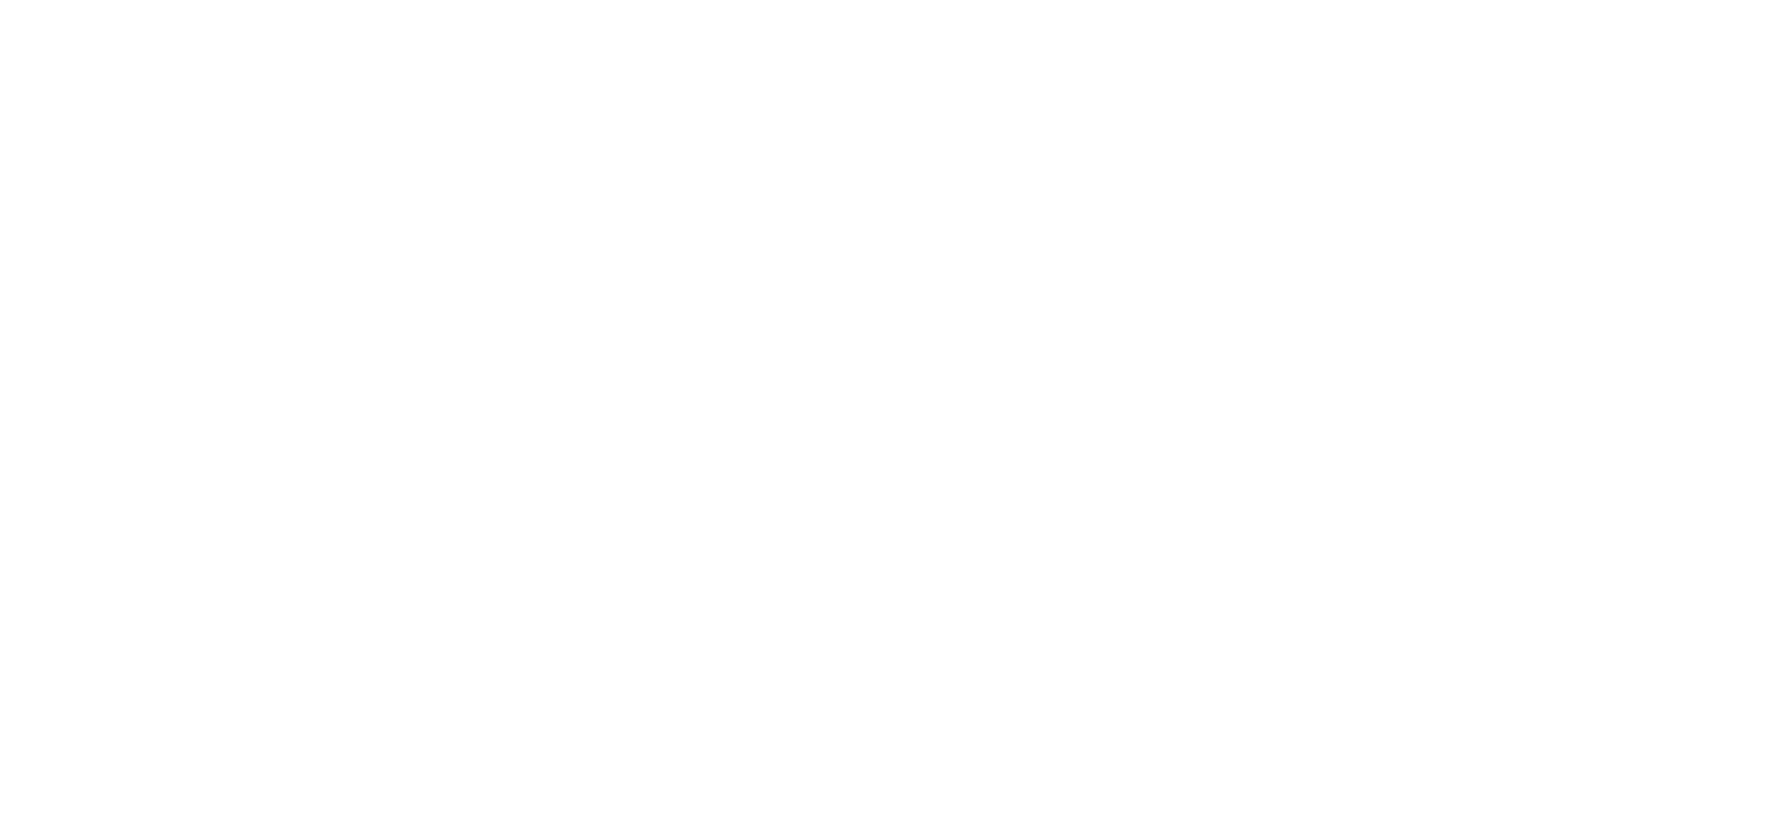

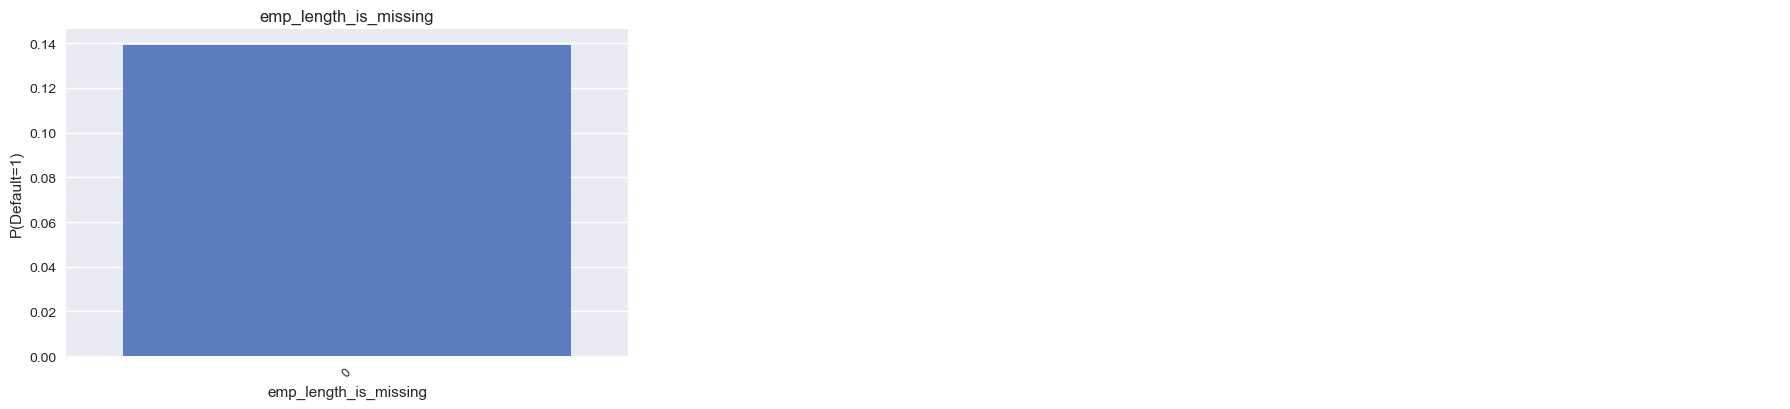

In [92]:
import re, difflib
import pandas as pd
import numpy as np

# 0) Quick peek
#print("Columns:", len(df_uncorr2.columns))
#print(df_uncorr2.dtypes.value_counts())
#print(df_uncorr2.columns[:25].tolist())

# 1) helper: suggest close matches
def suggest(col, cols, n=3):
    return difflib.get_close_matches(col, cols, n=n, cutoff=0.6)

# 2) helper: ensure indicators exist (creates <base>__is_missing)
def ensure_missing_indicators(df, bases):
    created = []
    for base in bases:
        ind = f"{base}__is_missing"
        if ind not in df.columns and base in df.columns:
            df[ind] = df[base].isna().astype("int8")
            created.append(ind)
    return created

# 3) helper: resolve feature names (checks variants + suggests)
def resolve_features(df, requested, is_indicator=False):
    cols = set(df.columns)
    resolved, missing = [], []
    for f in requested:
        if f in cols:
            resolved.append(f); continue
        cand = []
        if is_indicator:
            # try common variants
            base = re.sub(r"(__is_missing|_is_missing)$", "", f)
            variants = [f"{base}__is_missing", f"{base}_is_missing"]
            cand = [v for v in variants if v in cols]
        if not cand:
            # try close matches
            cand = suggest(f, list(cols), n=2)
        if cand:
            resolved.append(cand[0])
        else:
            missing.append(f)
    return resolved, missing

# 4) run: (re)create indicators you care about
created_inds = ensure_missing_indicators(
    df_uncorr2,
    bases=["emp_length", "annual_inc_joint", "dti_joint"]
)
if created_inds:
    print("Created indicators:", created_inds)

# 5) desired lists
num_feats_req = ["int_rate", "loan_amnt", "dti", "revol_util", "total_acc", "delinq_2yrs"]
cat_feats_req = ["emp_length_is_missing", "annual_inc_joint_is_missing", "dti_joint_is_missing"]

# resolve
num_feats_ok, num_feats_miss = resolve_features(df_uncorr2, num_feats_req, is_indicator=False)
cat_feats_ok, cat_feats_miss = resolve_features(df_uncorr2, cat_feats_req, is_indicator=True)

#print("Numeric OK:", num_feats_ok)
#print("Numeric missing:", {m: suggest(m, df_uncorr2.columns) for m in num_feats_miss})
#print("Categorical OK:", cat_feats_ok)
#print("Categorical missing:", {m: suggest(m, df_uncorr2.columns) for m in cat_feats_miss})

# 6) use with grid plotter
plot_default_prob_grid(df_uncorr2, num_feats_ok, target="target_default", n_cols=3, bins=6, strategy="quantile")
plot_default_prob_grid(df_uncorr2, cat_feats_ok, target="target_default", n_cols=3)

In [ ]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")